Connect to WRDS
username：yanqinglin
password：@Qiuqiulin0705

In [2]:
import wrds
db = wrds.Connection()

Enter your WRDS username [linyanqing]: yanqinglin
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


Extraction data from WRDS
Data Source:
- Database: WRDS OptionMetrics (optionm.opprcd2023)
- Underlying: S&P 500 Index (SPX, secid = 108105)
- Time Period: 2023-08-01 to 2023-08-31 （Maximum allowed date)

Variables:
- date: Observation date (daily)
- exdate: Option expiration date
- cp_flag: Option type (C = Call, P = Put)
- strike_price: Strike price in dollars (original value divided by 1000)
- best_bid: Highest closing bid price
- best_offer: Lowest closing ask price
- impl_volatility: Implied volatility
- delta: Option delta
- time_to_maturity: Days until expiration (exdate - date)

Rules:
- Only keep options with valid implied volatility
- Only keep options with positive bid prices (actively traded)
- Exclude options with invalid bid-ask spreads (best_offer > best_bid)
- minimum 7 days to expiration
- maximum 5 years to expiration

In [2]:
#import pandas as pd
#import numpy as np

# 
#start_date = '2000-08-01'
#end_date = '2023-08-31'

#query = """
#SELECT 
#    a.date,
#    a.exdate,
#    a.cp_flag,
#    a.strike_price / 1000.0 as strike_price,
#    a.best_bid,
#    a.best_offer,
#    a.impl_volatility,
#    a.delta,
#    (a.exdate - a.date) as time_to_maturity
#FROM 
#    optionm.opprcd2023 a
#WHERE 
#    a.secid = 108105
#    AND a.date BETWEEN '{start}' AND '{end}'
#    AND a.impl_volatility IS NOT NULL
#    AND a.impl_volatility > 0
#    AND a.impl_volatility < 1
#    AND a.best_bid > 0
#    AND a.best_offer > a.best_bid
#    AND (a.exdate - a.date) >= 7
#    AND (a.exdate - a.date) <= 1825
#""".format(start=start_date, end=end_date)

#df = db.raw_sql(query, date_cols=['date', 'exdate'])
#print(f"{len(df)} records")
#print(df.head(10))

In [17]:
import pandas as pd
import numpy as np

# 
start_date = '2000-08-31'
end_date = '2023-08-31'
start_year = 2000
end_year = 2023

queries = []
for year in range(start_year, end_year + 1):
    if year == start_year:
        # 2000/08/31 to 2000/12/31
        date_filter = f"AND a.date BETWEEN '{year}-08-31' AND '{year}-12-31'"
    elif year == end_year:
        # 2023/01/01 to 2023/08/31
        date_filter = f"AND a.date BETWEEN '{year}-01-01' AND '{year}-08-31'"
    else:
        # between 2000 and 2023, ex 2022/01/01 to 2022/12/31
        date_filter = ""
    
    query_part = f"""
    SELECT 
        a.date,
        a.exdate,
        a.cp_flag,
        a.strike_price / 1000.0 as strike_price,
        a.best_bid,
        a.best_offer,
        a.impl_volatility,
        a.delta,
        (a.exdate - a.date) as time_to_maturity
    FROM 
        optionm.opprcd{year} a
    WHERE 
        a.secid = 108105
        {date_filter}
        AND a.impl_volatility IS NOT NULL
        AND a.impl_volatility > 0
        AND a.impl_volatility < 1
        AND a.best_bid > 0
        AND a.best_offer > a.best_bid
        AND (a.exdate - a.date) >= 7
        AND (a.exdate - a.date) <= 1825
    """
    queries.append(query_part)

query = "\nUNION ALL\n".join(queries) + "\nORDER BY date, exdate"


df = db.raw_sql(query, date_cols=['date', 'exdate'])

print(f"\nFirst 10 rows:")
print(df.head(10))

print(f"\nLast 10 rows:")
print(df.tail(10))

# Save data
df.to_csv('raw_data.csv', index=False)


First 10 rows:
        date     exdate cp_flag  strike_price  best_bid  best_offer  \
0 2000-08-31 2000-09-16       C        1480.0    45.625      47.625   
1 2000-08-31 2000-09-16       P        1500.0    10.125      11.375   
2 2000-08-31 2000-09-16       P        1425.0    1.1875      1.6875   
3 2000-08-31 2000-09-16       P        1675.0   152.625     154.625   
4 2000-08-31 2000-09-16       C        1575.0    1.4375      1.9375   
5 2000-08-31 2000-09-16       C        1560.0     3.375       4.125   
6 2000-08-31 2000-09-16       P        1950.0    426.75      428.75   
7 2000-08-31 2000-09-16       P        1625.0   102.875     104.875   
8 2000-08-31 2000-09-16       P        1480.0      5.75        6.75   
9 2000-08-31 2000-09-16       C        1490.0    37.625      39.625   

   impl_volatility     delta  time_to_maturity  
0         0.155732  0.815666                16  
1         0.162182 -0.324113                16  
2         0.203772 -0.053439                16  
3     

In [4]:
# Retrieve SP500 underlying price data (August 2023)
#query_underlying = """
#SELECT 
#    date,
#    close as price
#FROM 
#    optionm.secprd2023
#WHERE 
#    secid = 108105
#    AND date BETWEEN '2000-08-01' AND '2023-08-31'
#"""

#underlying_df = db.raw_sql(query_underlying, date_cols=['date'])
#print(f"{len(underlying_df)} trading days")
#print(underlying_df.head())

In [18]:
# Retrieve SP500 underlying price data (until August 2023)

start_year = 2000
end_year = 2023

queries = []
for year in range(start_year, end_year + 1):
    if year == start_year:
        # 2000/8/31 to 2000/12/31
        date_filter = f"AND date BETWEEN '{year}-08-31' AND '{year}-12-31'"
    elif year == end_year:
        # 2023/01/01 to 2023/8/31
        date_filter = f"AND date BETWEEN '{year}-01-01' AND '{year}-08-31'"
    else:
        # ex: 2022/01/01 to 2022/12/31
        date_filter = ""
    
    query_part = f"""
    SELECT 
        date,
        close as price
    FROM 
        optionm.secprd{year}
    WHERE 
        secid = 108105
        {date_filter}
    """
    queries.append(query_part)

query_underlying = "\nUNION ALL\n".join(queries) + "\nORDER BY date"

underlying_df = db.raw_sql(query_underlying, date_cols=['date'])
print(f"{len(underlying_df)} trading days")
print(underlying_df.head())
print(underlying_df.tail())

5786 trading days
        date    price
0 2000-08-31  1517.68
1 2000-09-01  1520.77
2 2000-09-05  1507.08
3 2000-09-06  1492.25
4 2000-09-07  1502.51
           date    price
5781 2023-08-25  4405.71
5782 2023-08-28  4433.31
5783 2023-08-29  4497.63
5784 2023-08-30  4514.87
5785 2023-08-31  4507.66


In [19]:
# Retrieve risk-free rate data (until August 2023) using FF factor

query_ff = """
SELECT 
    date,
    rf
FROM ff.factors_daily
WHERE date BETWEEN '2000-08-31' AND '2023-08-31'
ORDER BY date
"""

rf_daily = db.raw_sql(query_ff, date_cols=['date'])

rf_daily['rf_decimal'] = rf_daily['rf'] / 100 

print(f"{len(rf_daily)} trading days")
print(rf_daily .head())
print(rf_daily .tail())

5786 trading days
        date      rf  rf_decimal
0 2000-08-31  0.0002    0.000002
1 2000-09-01  0.0003    0.000003
2 2000-09-05  0.0003    0.000003
3 2000-09-06  0.0003    0.000003
4 2000-09-07  0.0003    0.000003
           date      rf  rf_decimal
5781 2023-08-25  0.0002    0.000002
5782 2023-08-28  0.0002    0.000002
5783 2023-08-29  0.0002    0.000002
5784 2023-08-30  0.0002    0.000002
5785 2023-08-31  0.0002    0.000002


In [20]:
# Merge the three datasets
data = df.merge(underlying_df, on='date', how='left')
data = data.merge(rf_daily[['date', 'rf_decimal']], on='date', how='left') 
data = data[['date', 'cp_flag', 'strike_price', 'price', 'impl_volatility', 'time_to_maturity', 'rf_decimal']]
print(f"\nMerged dataset contains {len(data)} records")

print(data.head(10))


Merged dataset contains 28918385 records
        date cp_flag  strike_price    price  impl_volatility  \
0 2000-08-31       C        1480.0  1517.68         0.155732   
1 2000-08-31       P        1500.0  1517.68         0.162182   
2 2000-08-31       P        1425.0  1517.68         0.203772   
3 2000-08-31       P        1675.0  1517.68         0.249082   
4 2000-08-31       C        1575.0  1517.68         0.127056   
5 2000-08-31       C        1560.0  1517.68         0.129623   
6 2000-08-31       P        1950.0  1517.68          0.54058   
7 2000-08-31       P        1625.0  1517.68         0.186785   
8 2000-08-31       P        1480.0  1517.68           0.1717   
9 2000-08-31       C        1490.0  1517.68         0.153043   

   time_to_maturity  rf_decimal  
0                16    0.000002  
1                16    0.000002  
2                16    0.000002  
3                16    0.000002  
4                16    0.000002  
5                16    0.000002  
6              

Moneyness Calculation using Equation (4)

M = (1/√τ) × log(F_t,τ / K)

where:
- K is the strike price
- τ is the time to maturity in days
- F_t,τ is the forward price of SP500 with maturity τ

F_t,τ = S_t × e^(r×τ)
- r is approximately 5.33% for August 2023
- the average r is approximately near 3.5% to 4% cross 2000 to 2023, use for simplify the calculations.

In [21]:
# Calculate tau (time to maturity in years)
data['YTM'] = data['time_to_maturity'] / 365.0

# Calculate the daily risk-free rates to maturity-matched continuously compounded rates.
data['rf'] = np.log(1 + data['rf_decimal']) * data['YTM']

# Calculate forward price
data['F'] = data['price'] * np.exp(data['rf'])

# Calculate moneyness
data['M'] = (1 / np.sqrt(data['YTM'])) * np.log(data['F'] / data['strike_price'])

# Save data
data.to_csv('data.csv', index=False)
print(data.head(10))

        date cp_flag  strike_price    price  impl_volatility  \
0 2000-08-31       C        1480.0  1517.68         0.155732   
1 2000-08-31       P        1500.0  1517.68         0.162182   
2 2000-08-31       P        1425.0  1517.68         0.203772   
3 2000-08-31       P        1675.0  1517.68         0.249082   
4 2000-08-31       C        1575.0  1517.68         0.127056   
5 2000-08-31       C        1560.0  1517.68         0.129623   
6 2000-08-31       P        1950.0  1517.68          0.54058   
7 2000-08-31       P        1625.0  1517.68         0.186785   
8 2000-08-31       P        1480.0  1517.68           0.1717   
9 2000-08-31       C        1490.0  1517.68         0.153043   

   time_to_maturity  rf_decimal       YTM   rf            F         M  
0                16    0.000002  0.043836  0.0  1517.680133  0.120079  
1                16    0.000002  0.043836  0.0  1517.680133  0.055967  
2                16    0.000002  0.043836  0.0  1517.680133  0.300956  
3      

Estimation for Beta Parameters

OLS Model：

σ(M,τ) = β₁ + β₂·(Time to maturity slope) + β₃·(Moneyness slope) + β₄·(Smile attenuation) + β₅·(Smirk)

Parameters:
- T_max = 5 years
- T_conv = 0.25 years

Independent variables,X:
- X1 = 1
- X2 = Time to maturity slope = exp(-√(τ/T_conv))
- X3 = Moneyness slope = M·𝟙{M≥0} + [(e^(2M) - 1)/(e^(2M) + 1)]·𝟙{M<0}
- X4 = Smile attenuation = (1 - exp(-M²)) × log(τ/T_max)
- X5 = Smirk = [1 - exp((3M)³)] × log(τ/T_max) × 𝟙{M<0}

We use Bayesian priors as regularization to stabilize parameter estimates and preserve economic interpretability.
- β₁，prior = ATM_1y,
- β₂，prior = (ATM_1y - ATM_1m)/exp(-√(4/12)), 
- β₃，prior = β₃,t-1
- β₄，prior = uninformative
- β₅，prior = β₅,t-1

In [23]:
from sklearn.linear_model import LinearRegression
import warnings

# Ignore exp() overflow warning. 
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Parameters
T_max = 5.0      # 5 years
T_conv = 0.25    # 0.25 years

dates = sorted(data['date'].unique()) # Get all unique dates
# Store results
results = []

for date in dates:
    # Filter data for the date
    daily_data = data[data['date'] == date].copy()  
    
    # Calculate Priors, β_prior
    # 1-year ATM IV (τ = 1.0 and M = 0)
    atm_1y_data = daily_data[(daily_data['YTM'] == 1) & (abs(daily_data['M']) < 0.03)]
    atm_1y = atm_1y_data['impl_volatility'].mean() if len(atm_1y_data) > 0 else 0
    # 1-month ATM IV (τ = 1/12 and M = 0)
    atm_1m_data = daily_data[(daily_data['YTM'] == 1/12) & (abs(daily_data['M']) < 0.03)]
    atm_1m = atm_1m_data['impl_volatility'].mean() if len(atm_1m_data) > 0 else 0

    # β₁ prior
    beta1_prior = atm_1y 

    # β₂ prior
    beta2_prior = (atm_1y - atm_1m) / np.exp(-np.sqrt(4/12))

    # β₃ prior
    beta3_prior = results[-1]['beta3'] if len(results) > 0 else 0.0

    # β₄ prior skip

    # β₅ prior
    beta5_prior = results[-1]['beta5'] if len(results) > 0 else 0.0
    
    
    # Calculate independent variables, X
    # X1 = 1
    X1 = np.ones(len(daily_data))
    
    # X2 = Time to maturity slope 
    X2 = np.exp(-np.sqrt(daily_data['YTM'] / T_conv))
    
    # X3 = Moneyness slope
    X3 = np.where(
        daily_data['M'] < 0,
        (np.exp(2*daily_data['M']) - 1) / (np.exp(2*daily_data['M']) + 1),
        daily_data['M'],
    )
    
    # X4 = Smile attenuation
    X4 = (1 - np.exp(-daily_data['M']**2)) * np.log(daily_data['YTM'] / T_max)
    
    # X5 = Smirk
    X5 = np.where(
        daily_data['M'] < 0,
        (1 - np.exp((3*daily_data['M'])**3)) * np.log(daily_data['YTM'] / T_max),
        0
    )
    
    # X = independent variables
    X = np.column_stack([X1, X2, X3, X4, X5])
    
    # Y = observed implied volatilities
    Y = daily_data['impl_volatility'].values
    
    # R matrix
    R = np.array([
        [1, 0, 0, 0, 0],  # β1 prior
        [0, 1, 0, 0, 0],  # β2 prior
        [0, 0, 1, 0, 0],  # β3 prior
        [0, 0, 0, 0, 1],  # β5 prior 
    ])
    
    # beta prior vector
    beta_prior = np.array([beta1_prior, beta2_prior, beta3_prior, beta5_prior])
    
    # Stack the matrix and vector
    X_aug = np.vstack([X, R])  
    Y_aug = np.concatenate([Y, beta_prior])  
    
    # Bayesian Linear Regression
    # For simplicity, Ω is set to the identity matrix
    beta_hat = np.linalg.lstsq(X_aug, Y_aug, rcond=None)[0]

    # Calculate R-squared
    y_pred = X_aug[:len(daily_data)] @ beta_hat  # Predicted IV for observed data only
    y_true = Y  # Observed IV
    ss_res = np.sum((y_true - y_pred)**2)  # Residual sum of squares
    ss_tot = np.sum((y_true - y_true.mean())**2)  # Total sum of squares
    r_squared = 1 - (ss_res / ss_tot)

    # Store results
    results.append({
        'date': date,
        'beta1': beta_hat[0],
        'beta2': beta_hat[1],
        'beta3': beta_hat[2],
        'beta4': beta_hat[3],
        'beta5': beta_hat[4],
        'r_squared': r_squared
    })

# Convert results to DataFrame
beta = pd.DataFrame(results)
print(beta)

# Save data
beta.to_csv('beta.csv', index=False)

           date     beta1     beta2     beta3     beta4     beta5  r_squared
0    2000-08-31  0.204928 -0.110052  0.091090 -0.089371 -0.015301   0.840976
1    2000-09-01  0.204073 -0.101667  0.099712 -0.083733 -0.027232   0.828137
2    2000-09-05  0.199099 -0.037396  0.138027 -0.074539 -0.001226   0.881769
3    2000-09-06  0.203079 -0.047588  0.076458 -0.092478  0.004052   0.814621
4    2000-09-07  0.202917 -0.049646  0.111528 -0.091773  0.017476   0.924781
...         ...       ...       ...       ...       ...       ...        ...
5781 2023-08-25  0.203492 -0.147086  0.213966 -0.034079 -0.045371   0.909230
5782 2023-08-28  0.202778 -0.148960  0.219636 -0.026645 -0.043330   0.916771
5783 2023-08-29  0.202274 -0.160803  0.200235 -0.041262 -0.049204   0.898686
5784 2023-08-30  0.202152 -0.167830  0.204139 -0.039791 -0.047252   0.919325
5785 2023-08-31  0.193124 -0.145821  0.243577 -0.023009 -0.039492   0.958627

[5786 rows x 7 columns]


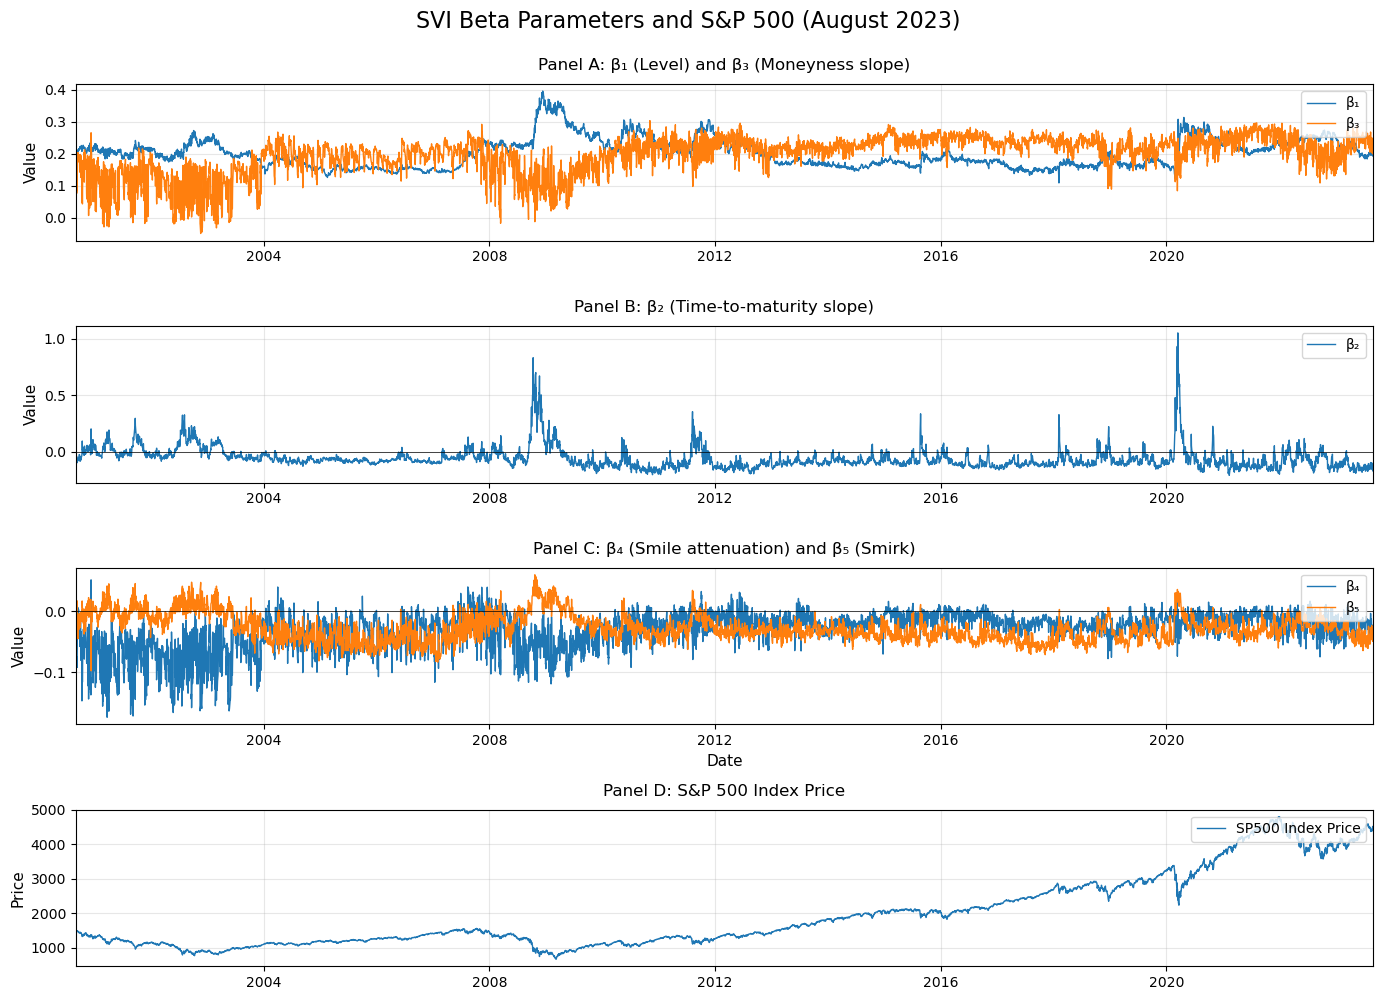

In [25]:
# Plot Beta Estimation
import matplotlib.pyplot as plt

# Create figure with 3 panels
fig, axes = plt.subplots(4, 1, figsize=(14, 10))
fig.suptitle('SVI Beta Parameters and S&P 500 (August 2023)', fontsize=16, y=0.995)

# Panel A: β₁ (Level) and β₃ (Moneyness slope)
ax1 = axes[0]
ax1.plot(beta['date'], beta['beta1'], linewidth=1, label='β₁', color='#1f77b4')
ax1.plot(beta['date'], beta['beta3'], linewidth=1, label='β₃', color='#ff7f0e')
ax1.set_ylabel('Value', fontsize=11)
ax1.set_title('Panel A: β₁ (Level) and β₃ (Moneyness slope)', fontsize=12, pad=10)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(beta['date'].min(), beta['date'].max())

# Panel B: β₂ (Time-to-maturity slope)
ax2 = axes[1]
ax2.plot(beta['date'], beta['beta2'], linewidth=1, label='β₂', color='#1f77b4')
ax2.set_ylabel('Value', fontsize=11)
ax2.set_title('Panel B: β₂ (Time-to-maturity slope)', fontsize=12, pad=10)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlim(beta['date'].min(), beta['date'].max())

# Panel C: β₄ (Smile attenuation) and β₅ (Smirk)
ax3 = axes[2]
ax3.plot(beta['date'], beta['beta4'], linewidth=1, label='β₄', color='#1f77b4')
ax3.plot(beta['date'], beta['beta5'], linewidth=1, label='β₅', color='#ff7f0e')
ax3.set_ylabel('Value', fontsize=11)
ax3.set_xlabel('Date', fontsize=11)
ax3.set_title('Panel C: β₄ (Smile attenuation) and β₅ (Smirk)', fontsize=12, pad=10)
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_xlim(beta['date'].min(), beta['date'].max())

# Panel D
ax4 = axes[3]
ax4.plot(underlying_df['date'], underlying_df['price'], linewidth=1, label='SP500 Index Price', color='#1f77b4')
ax4.set_ylabel('Price', fontsize=11)
ax4.set_title('Panel D: S&P 500 Index Price', fontsize=12, pad=10)
ax4.legend(loc='upper right', fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_xlim(underlying_df['date'].min(), underlying_df['date'].max())

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
